 # Examining Environmental Justice through Open Source, Cloud-Native Tools: R

This Jupyter (ipynb) notebook provides a brief introduction to a cloud-native workflow.  A more complete version of this example can be found in the intro.qmd Quarto notebook.  Here, we merely include an `ipynb` version to demonstrate how Jupyter notebooks may be included in quarto.

_Note: in Codespaces editor, choose "Select Kernel" -> "Jupyter Kernels" to get started._

Developer note: At this time, Gitpod VSCode editor will not detect the default python environment (VIRTUAL_ENV variable, pointing to `/opt/venv/bin/python`), or any other kernelspec added with ipykernel.  

In [1]:
from pystac_client import Client
import odc.stac
import pystac_client
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
box = [-122.51006, 37.70801, -122.36268, 37.80668]
client = Client.open("https://earth-search.aws.element84.com/v1")
search = client.search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2022-06-01/2022-08-01",
    query={"eo:cloud_cover": {"lt": 20}}
)

In [3]:
items = search.get_all_items()
# items[0]  # peak at an item

In [4]:
data = odc.stac.load(
    items,
    crs="EPSG:32610",
    bands=["nir08", "red"],
    resolution=30,
    bbox=box
)

In [5]:
red = data.red
nir = data.nir08

# summarize over time. 
# quite probably better to use resampling strategy in odc.stac.load though.
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    ndvi = ( ((nir - red) / (red + nir)).
            resample(time="MS").
            median("time", keep_attrs=True).
            compute()
    )

# mask out bad pixels
ndvi = ndvi.where(ndvi <= 1)

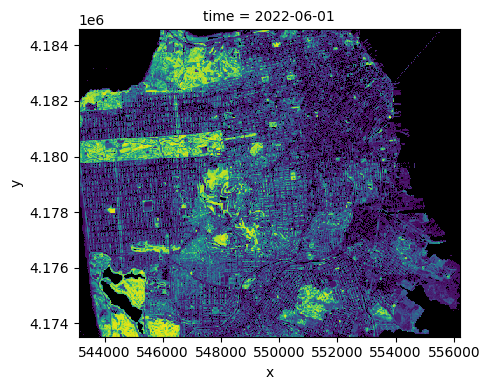

In [6]:
import matplotlib as plt
cmap = plt.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ndvi.plot.imshow(row="time", cmap=cmap, add_colorbar=False, size=4)